# Getting LFRic output on a rectiliniear lat-lon grid

Note: you need to install [python-stratify](https://github.com/SciTools/python-stratify) and [esmpy](https://earthsystemmodeling.org/esmpy/).
The best way to do it is to use conda/mamba:
```shell
conda install -c conda-forge python-stratify esmpy
```

In [1]:
from functools import partial
from pathlib import Path

import iris
from aeolus.io import create_dummy_cube
from aeolus.lfric import (
    add_equally_spaced_height_coord,
    fix_time_coord,
    load_lfric_raw,
    simple_regrid_lfric,
)
from aeolus.model import lfric

## 0. Using XIOS

To re-run LFRic with output on a lat-lon grid, follow this [guide](https://github.com/exoclim/.github/wiki/XIOS#examples-of-the-output-on-a-lat-lon-grid).

If the output is already on the native cubed sphere mesh, follow the steps below.

## 1. Using aeolus functions in a script or notebook

### 1.1. Load the raw data

Set the input file name as a `Path` object.

In [2]:
sample_file = (
    Path.cwd().parent
    / "tests"
    / "data"
    / "test_data"
    / "netcdf"
    / "lfric"
    / "1"
    / "run_gungho_model_shallow-hot-jupiter_C24_MG_dt-2400p0_intel_64-bit_fast-debug"
    / "lfric_diag.nc"
)

Optionally, define what coordinates should be deleted.

In [3]:
drop_coord = ["forecast_reference_time"]

Define callback functions to add the vertical height coordinate and clean up the time dimension metadata.

In [4]:
_add_levs = partial(add_equally_spaced_height_coord, model_top_height=3.29689e6)
_fix_time = partial(fix_time_coord, downgrade_to_scalar=True)


def _combi_callback(cube, field, filename):
    return _fix_time(
        _add_levs(cube, field, filename), field, filename, downgrade_to_scalar=True
    )

Load the data using a wrapper function from aeolus.

In [5]:
cubes_raw = load_lfric_raw(sample_file, callback=_combi_callback, drop_coord=drop_coord)
print(cubes_raw)

0: Axial Angular Momentum on W3 points / (kg m2 s-1) (half_levels: 32; -- : 3456)
1: Horisontal kinetic energy on W3 points / (J) (half_levels: 32; -- : 3456)
2: Vertical kinetic energy on W3 points / (J) (half_levels: 32; -- : 3456)
3: air_density / (kg m-3)              (half_levels: 32; -- : 3456)
4: air_potential_temperature / (K)     (full_levels: 33; -- : 3456)
5: air_pressure / (1)                  (full_levels: 33; -- : 3456)
6: atmosphere_mass_of_air_per_unit_area / (kg m-2) (-- : 3456)
7: eastward_wind / (ms-1)              (half_levels: 32; -- : 3456)
8: northward_wind / (ms-1)             (half_levels: 32; -- : 3456)
9: physics W wind on W3 points / (ms-1) (half_levels: 32; -- : 3456)
10: potential_temperature_increment_from_slow_physics / (K) (full_levels: 33; -- : 3456)
11: pressure_at_cell_interfaces / (Pa)  (full_levels: 33; -- : 3456)


### 1.2. Regrid all cubes horizontally and vertically

Create an empty cube with a lat-lon grid as a target for regridding.
For example, 96 longitudes is equivalent to the resolution of the C24 mesh at the equator.
We use `pm180=True` so that longitudes range from -180 to 180 instead of 0 to 360.

In [6]:
tgt_cube = create_dummy_cube(nlat=48, nlon=96, pm180=True)

Select a cube within the input dataset to serve as a target for the interpolation along the height dimension, i.e. in the vertical.
This way, all cubes will be on the same grid in 3 dimensions.
If the vertical interpolation is not needed, set `interp_vertically=False`.

Now, regrid the dataset and print out the resulting cube list.

In [7]:
cubes_regr = simple_regrid_lfric(
    cubes_raw, tgt_cube=tgt_cube, ref_cube_constr="air_potential_temperature"
)
print(cubes_regr)

0: Axial Angular Momentum on W3 points / (kg m2 s-1) (level_height: 33; latitude: 48; longitude: 96)
1: Horisontal kinetic energy on W3 points / (J) (level_height: 33; latitude: 48; longitude: 96)
2: Vertical kinetic energy on W3 points / (J) (level_height: 33; latitude: 48; longitude: 96)
3: air_density / (kg m-3)              (level_height: 33; latitude: 48; longitude: 96)
4: air_potential_temperature / (K)     (level_height: 33; latitude: 48; longitude: 96)
5: air_pressure / (1)                  (level_height: 33; latitude: 48; longitude: 96)
6: atmosphere_mass_of_air_per_unit_area / (kg m-2) (latitude: 48; longitude: 96)
7: eastward_wind / (ms-1)              (level_height: 33; latitude: 48; longitude: 96)
8: northward_wind / (ms-1)             (level_height: 33; latitude: 48; longitude: 96)
9: physics W wind on W3 points / (ms-1) (level_height: 33; latitude: 48; longitude: 96)
10: potential_temperature_increment_from_slow_physics / (K) (level_height: 33; latitude: 48; longitude: 9

### 1.3. Make a few simple plots

In [8]:
import matplotlib.colors as mcol
import matplotlib.pyplot as plt

plt.rcParams["mathtext.default"] = "regular"

#### 1.3.1. Horizontal slice of potential temperature

Extract a cube of potential temperature from the regridded dataset and select a height level closest to 123,456 m.

In [9]:
cube = cubes_regr.extract_cube("air_potential_temperature")
if not cube.coord("level_height").has_bounds():
    cube.coord("level_height").guess_bounds()
cube_slice = cube.extract(iris.Constraint(level_height=123_456))
print(cube_slice)

air_potential_temperature / (K)     (latitude: 48; longitude: 96)
    Dimension coordinates:
        latitude                             x              -
        longitude                            -              x
    Scalar coordinates:
        forecast_period             102816000.0 seconds
        level_height                103027.8125 m, bound=(51513.90625, 154541.71875) m
        time                        2019-04-05 15:00:00, bound=(2019-04-05 15:00:00, 2019-04-05 15:00:00)
    Cell methods:
        0                           time: point (interval: 2400 s)
    Attributes:
        Conventions                 'UGRID-1.0'
        description                 'LFRic file format v0.2.0'
        interval_operation          '2400 s'
        interval_write              '1.728e+06 s'
        name                        'lfric_diag'
        online_operation            'instant'
        title                       'Created by xios'


For convenience, extract the latitude and longitude arrays.

In [10]:
lats = cube_slice.coord("latitude").points
lons = cube_slice.coord("longitude").points

Assemble the figure.

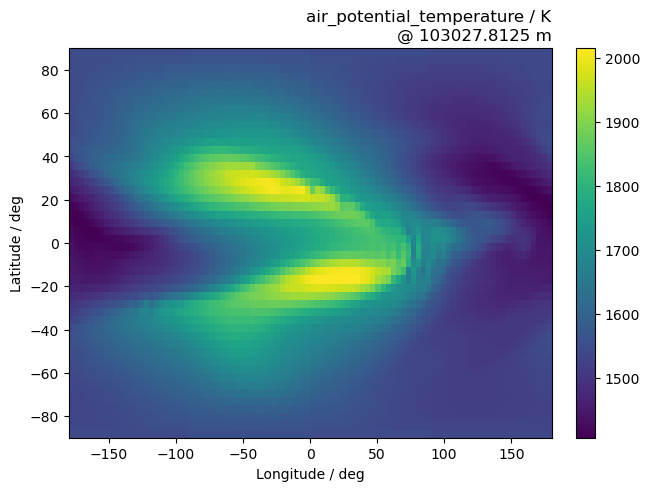

In [11]:
fig, ax = plt.subplots(constrained_layout=True)
im = ax.pcolormesh(lons, lats, cube_slice.data)
fig.colorbar(im)
ax.set_title(
    f"{cube_slice.name()} / {cube_slice.units}"
    f"\n@ {cube_slice.coord('level_height').points[0]} {cube_slice.coord('level_height').units}",
    loc="right",
)
ax.set_ylim(-90, 90)
ax.set_xlim(-180, 180)
ax.set_ylabel("Latitude / deg")
ax.set_xlabel("Longitude / deg");

#### 1.3.2. Horizontal wind vectors

In [12]:
from aeolus.coord import isel

Extract eastward and northward components of the wind from the regridded dataset.

In [13]:
cube_u = cubes_regr.extract_cube("eastward_wind")
cube_v = cubes_regr.extract_cube("northward_wind")

Select a random slice w.r.t. the vertical axis.

In [14]:
cube_u_slice = isel(cube_u, "level_height", 11)  # equivalent to `cube_u[11, ...]`
cube_v_slice = isel(cube_v, "level_height", 11)  # equivalent to `cube_u[11, ...]`

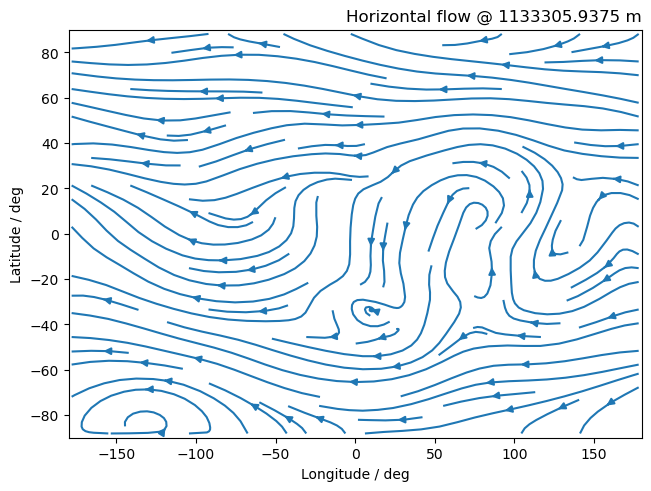

In [15]:
fig, ax = plt.subplots(constrained_layout=True)
ax.streamplot(
    lons,
    lats,
    cube_u_slice.data,
    cube_v_slice.data,
)
ax.set_title(
    f"Horizontal flow @ {cube_u_slice.coord('level_height').points[0]} {cube_u_slice.coord('level_height').units}",
    loc="right",
)
ax.set_ylim(-90, 90)
ax.set_xlim(-180, 180)
ax.set_ylabel("Latitude / deg")
ax.set_xlabel("Longitude / deg");

#### 1.3.3. Zonal mean eastward wind

In [16]:
from aeolus.calc import zonal_mean

In [17]:
u_zm = zonal_mean(cubes_regr.extract_cube("eastward_wind"))

Text(0.5, 1.0, 'Zonal mean eastward wind')

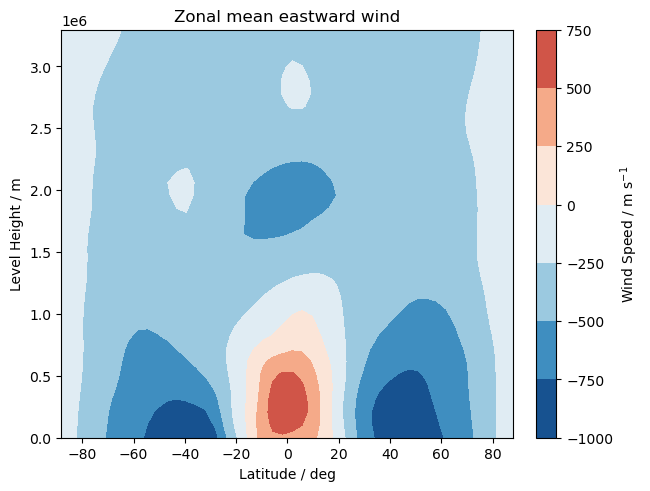

In [18]:
fig, ax = plt.subplots(constrained_layout=True)

p0 = ax.contourf(
    u_zm.coord("latitude").points,
    u_zm.coord("level_height").points,
    u_zm.data,
    cmap="RdBu_r",
    norm=mcol.CenteredNorm(),
)
cb0 = fig.colorbar(p0, ax=ax)
cb0.ax.set_ylabel("Wind Speed / $m$ $s^{-1}$")

ax.set_ylabel("Level Height / m")
ax.set_xlabel("Latitude / deg")

ax.set_title("Zonal mean eastward wind")

#### 1.3.4. Interpolate the data to isobaric (constant pressure levels)

It is often more informative to visualise the vertical structure of the atmosphere with respect to pressure.
Let us interpolate our data to isobaric levels and plot the zonal mean cross-section with pressure as the y-axis.

In [19]:
import numpy as np
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from iris.experimental import stratify

Create a callable to pass to the interpolation routine.
Use linear extrapolation.

In [20]:
INTERPOLATOR = partial(
    stratify.stratify.interpolate,
    interpolation=stratify.stratify.INTERPOLATE_LINEAR,
    extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
)

Temporarily rename the pressure variable in the `lfric` registry.

If your output contains another pressure variable, change it accordingly.

In [21]:
lfric.pres = "pressure_at_cell_interfaces"  # optional

Interpolate the eastward wind component to the levels of constant pressure.

In [22]:
(pres_lev := np.arange(1e5, 0, -1e4))

array([100000.,  90000.,  80000.,  70000.,  60000.,  50000.,  40000.,
        30000.,  20000.,  10000.])

In [23]:
u_p = interp_cube_from_height_to_pressure_levels(
    cubes_regr.extract_cube("eastward_wind"),
    cubes_regr.extract_cube("pressure_at_cell_interfaces"),
    levels=pres_lev,
    model=lfric,
    interpolator=INTERPOLATOR,
)

Apply zonal averaging.

In [24]:
u_p_zm = zonal_mean(u_p)

Create the same figure but with pressure as the y-axis (in the logarithmic scale).

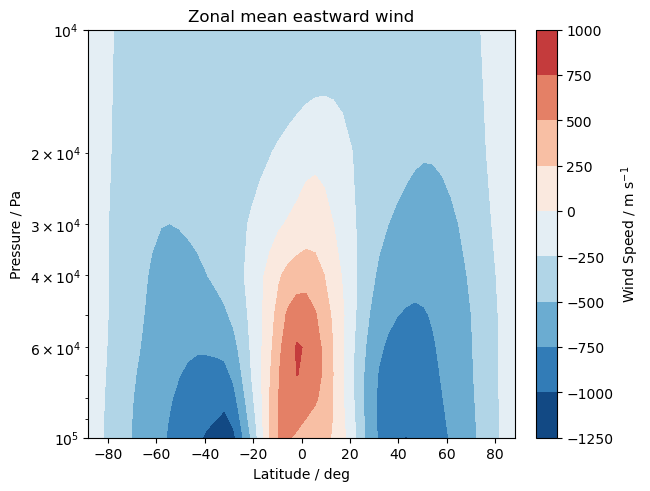

In [25]:
fig, ax = plt.subplots(constrained_layout=True)

p0 = ax.contourf(
    u_p_zm.coord("latitude").points,
    u_p_zm.coord(lfric.pres).points,
    u_p_zm.data,
    cmap="RdBu_r",
    norm=mcol.CenteredNorm(),
)
cb0 = fig.colorbar(p0, ax=ax)
cb0.ax.set_ylabel("Wind Speed / $m$ $s^{-1}$")

ax.set_ylim(1e5, 1e4)
ax.set_yscale("log")

ax.set_ylabel("Pressure / Pa")
ax.set_xlabel("Latitude / deg")

ax.set_title("Zonal mean eastward wind");

## 2. Using the "all inclusive" function in aeolus

The regridding steps 1.1-1.2 above can be done using the `process_lfric` function.
Note that it expects the input directory structure as it is currently in LFRic's rose-stem test suite.

In [26]:
import tempfile

from aeolus.postprocess import process_lfric

In [27]:
inpdir = Path("..") / "tests" / "data" / "test_data" / "netcdf" / "lfric"
outdir = Path(tempfile.mkdtemp())
label = "shj"
planet = ""  # do not add planet constants to the output file
c_num = "C24"
ref_cube = "air_potential_temperature"
level_height = "uniform"
top_height = 3.29689e6
time_prof = "inst"
file_chunk_size = 1
nlat = 48
nlon = 96

In [28]:
fname_out = process_lfric(
    inpdir,
    outdir,
    label,
    planet,
    c_num,
    ref_cube,
    level_height,
    top_height,
    time_prof,
    file_chunk_size,
    nlat,
    nlon,
)

2024-11-07 14:40:03.089 | INFO     | aeolus.postprocess:process_lfric:128 - fnames(1) = ../tests/data/test_data/netcdf/lfric/1/run_gungho_model_shallow-hot-jupiter_C24_MG_dt-2400p0_intel_64-bit_fast-debug/lfric_diag.nc
2024-11-07 14:40:04.208 | SUCCESS  | aeolus.postprocess:process_lfric:174 - Saved to /tmp/tmpkv1oabui/shj_c24_inst__001-001_regr.nc
2024-11-07 14:40:04.208 | INFO     | aeolus.postprocess:process_lfric:175 - Execution time: 1.1s


In [29]:
cubes_regr = iris.load(outdir / "shj_c24_inst__001-001_regr.nc")
print(cubes_regr)

0: potential_temperature_increment_from_slow_physics / (K) (level_height: 33; latitude: 48; longitude: 96)
1: Vertical kinetic energy on W3 points / (J) (level_height: 33; latitude: 48; longitude: 96)
2: atmosphere_mass_of_air_per_unit_area / (kg m-2) (latitude: 48; longitude: 96)
3: Axial Angular Momentum on W3 points / (kg m2 s-1) (level_height: 33; latitude: 48; longitude: 96)
4: pressure_at_cell_interfaces / (Pa)  (level_height: 33; latitude: 48; longitude: 96)
5: Horisontal kinetic energy on W3 points / (J) (level_height: 33; latitude: 48; longitude: 96)
6: physics W wind on W3 points / (m s-1) (level_height: 33; latitude: 48; longitude: 96)
7: air_density / (kg m-3)              (level_height: 33; latitude: 48; longitude: 96)
8: air_potential_temperature / (K)     (level_height: 33; latitude: 48; longitude: 96)
9: air_pressure / (1)                  (level_height: 33; latitude: 48; longitude: 96)
10: eastward_wind / (m s-1)             (level_height: 33; latitude: 48; longitude: 

## 3. Using aeolus in the command-line interface

The `process_lfric` function can also be invoked from the command line as following.

In [30]:
!aeolus pp --inpdir ../tests/data/test_data/netcdf/lfric --outdir ./tmp -m lfric -l shj -p "" --top_height 3.29689e6 -c C24 --ref_cube air_potential_temperature --file_chunk_size 1

Processing lfric output...
2024-11-07 14:40:05.568 | INFO     | aeolus.postprocess:process_lfric:128 - fnames(1) = ../tests/data/test_data/netcdf/lfric/1/run_gungho_model_shallow-hot-jupiter_C24_MG_dt-2400p0_intel_64-bit_fast-debug/lfric_diag.nc
2024-11-07 14:40:07.097 | SUCCESS  | aeolus.postprocess:process_lfric:174 - Saved to tmp/shj_c24_inst__001-001_regr.nc
2024-11-07 14:40:07.097 | INFO     | aeolus.postprocess:process_lfric:175 - Execution time: 1.5s
Saved to tmp/shj_c24_inst__001-001_regr.nc


In [31]:
cubes_regr = iris.load(Path("tmp") / "shj_c24_inst__001-001_regr.nc")
print(cubes_regr)

0: potential_temperature_increment_from_slow_physics / (K) (level_height: 33; latitude: 90; longitude: 144)
1: Vertical kinetic energy on W3 points / (J) (level_height: 33; latitude: 90; longitude: 144)
2: atmosphere_mass_of_air_per_unit_area / (kg m-2) (latitude: 90; longitude: 144)
3: Axial Angular Momentum on W3 points / (kg m2 s-1) (level_height: 33; latitude: 90; longitude: 144)
4: pressure_at_cell_interfaces / (Pa)  (level_height: 33; latitude: 90; longitude: 144)
5: Horisontal kinetic energy on W3 points / (J) (level_height: 33; latitude: 90; longitude: 144)
6: physics W wind on W3 points / (m s-1) (level_height: 33; latitude: 90; longitude: 144)
7: air_density / (kg m-3)              (level_height: 33; latitude: 90; longitude: 144)
8: air_potential_temperature / (K)     (level_height: 33; latitude: 90; longitude: 144)
9: air_pressure / (1)                  (level_height: 33; latitude: 90; longitude: 144)
10: eastward_wind / (m s-1)             (level_height: 33; latitude: 90; l

In [32]:
import shutil

shutil.rmtree("tmp")